In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from datetime import datetime, timedelta
# prophet model 
from fbprophet import Prophet
# prophet preformance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import os
from pydlm import dlm, trend, seasonality, autoReg
import warnings
warnings.filterwarnings('ignore')


In [18]:
file_name = 'covid_data.csv'
df = pd.read_csv(file_name)
df = df.loc[df['location']=='South Africa']
#df = df.loc[df['date']>='2020-03-06']
df['date'] = pd.to_datetime(df['date'])
df_ds = df[['date','new_cases']]
df_ds.columns = ["ds", "y"]
df_ds["y"] = df_ds["y"]
df_ds = df_ds[df_ds['y']>=1]

In [3]:
def plot_colname(dataf,column_name):
    fig = plt.figure(figsize=(16,10))
    
    ax1 = fig.add_subplot(111)
    ax1.grid(False)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.set_palette("husl", 3)

    sns.lineplot(x  = 'date', 
                 y = column_name,
                 data = dataf, 
                 ax = ax1,
                 ci = None
                )
    fig.autofmt_xdate()
    plt.xlabel( column_name +'_per_day' ,
               fontweight='bold', 
               color = 'k', 
               fontsize='17', 
               horizontalalignment='center')

In [4]:
plot_columns = ['total_cases', 
                'new_cases',
                'total_deaths', 
                'new_deaths', 
                'total_cases_per_million',
                'new_cases_per_million',
                'total_deaths_per_million',
                'new_deaths_per_million', 
                'total_tests', 'new_tests',
                'total_tests_per_thousand',
                'new_tests_per_thousand'
               ]

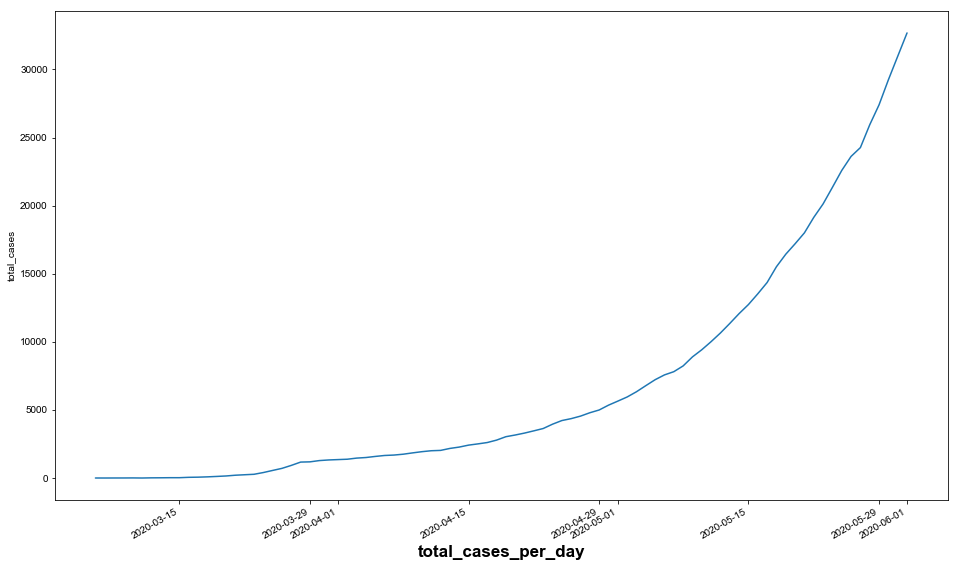

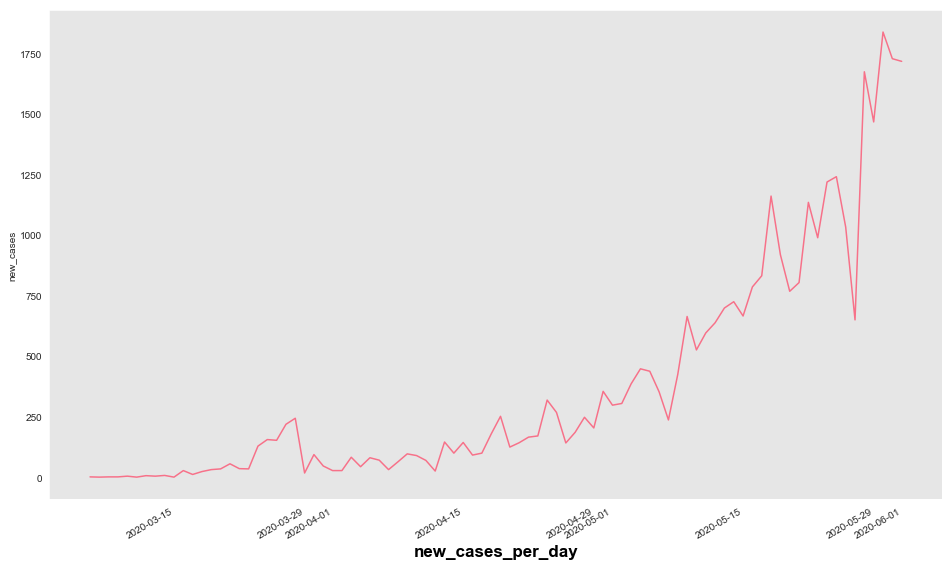

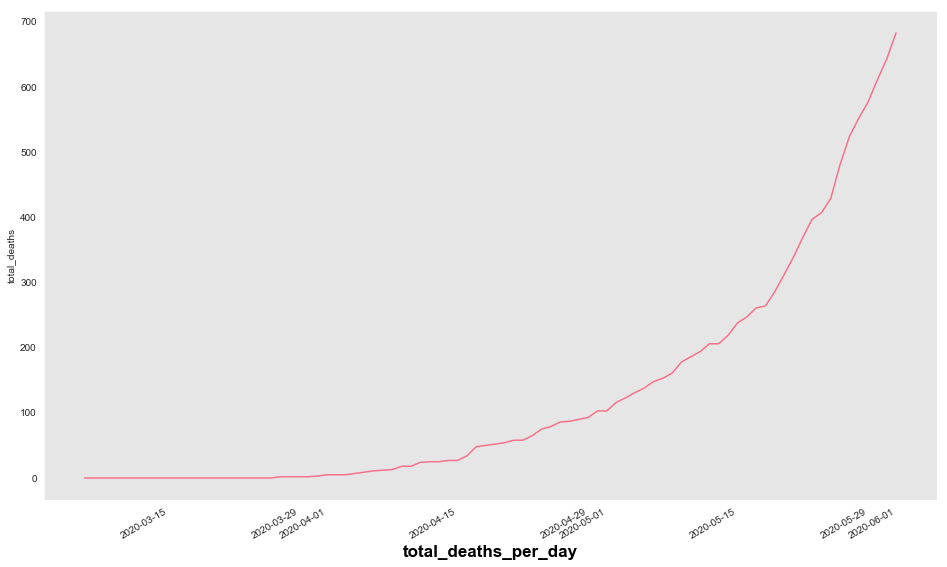

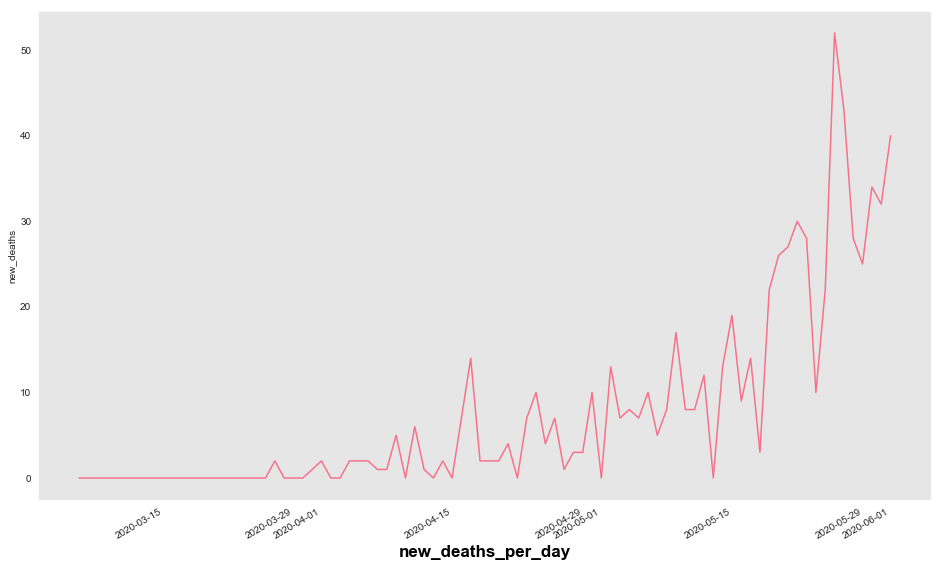

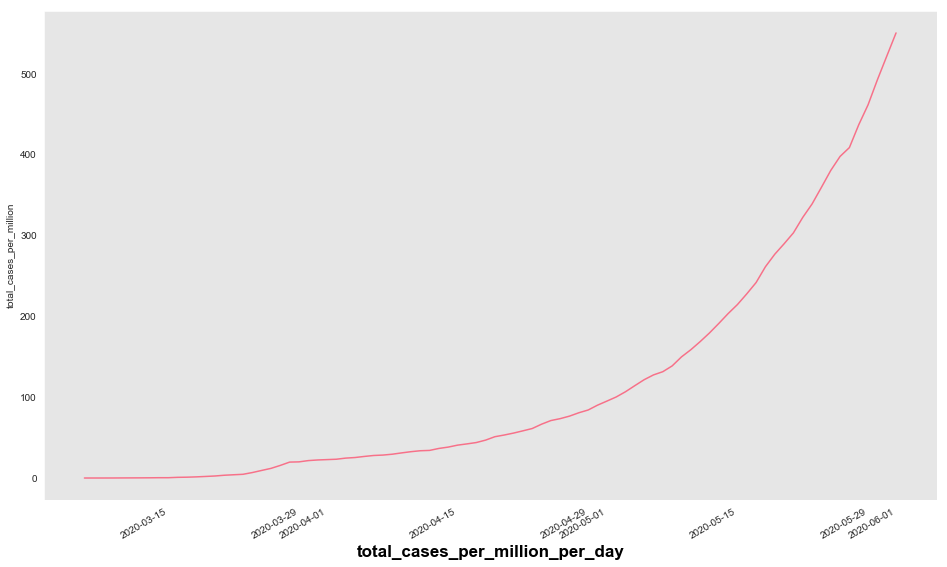

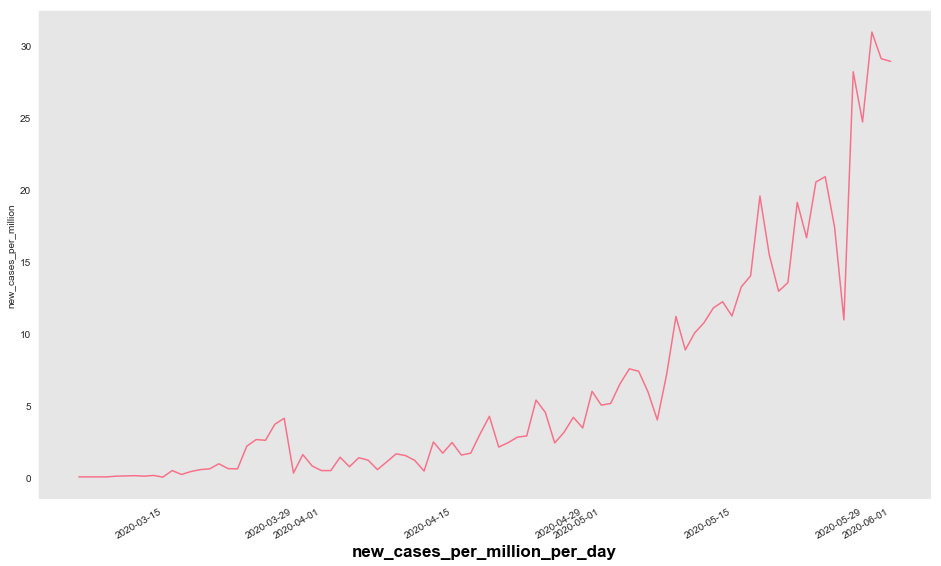

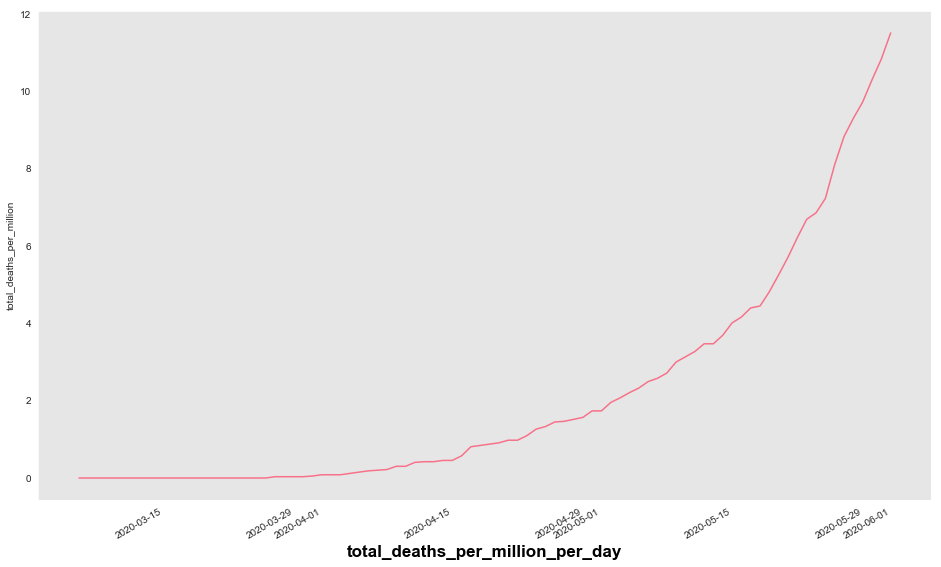

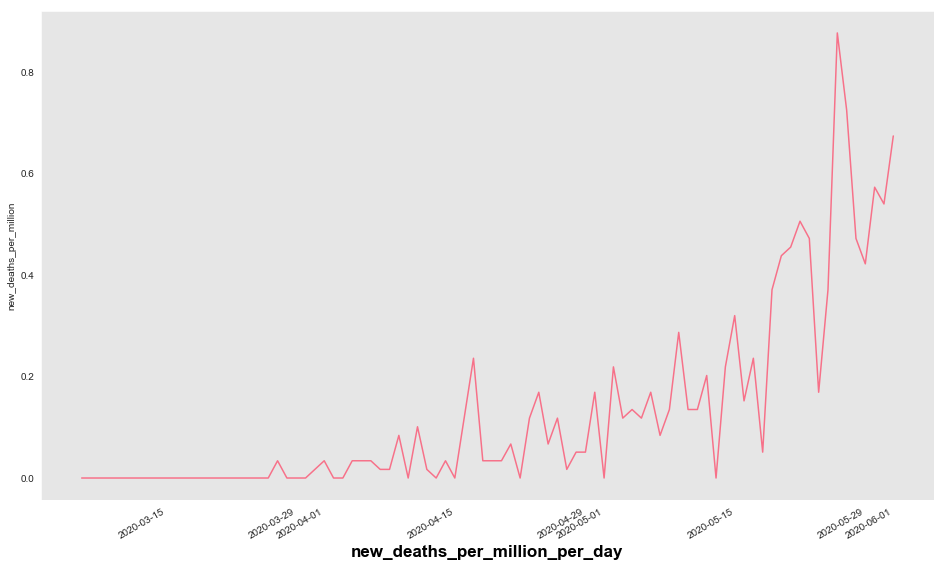

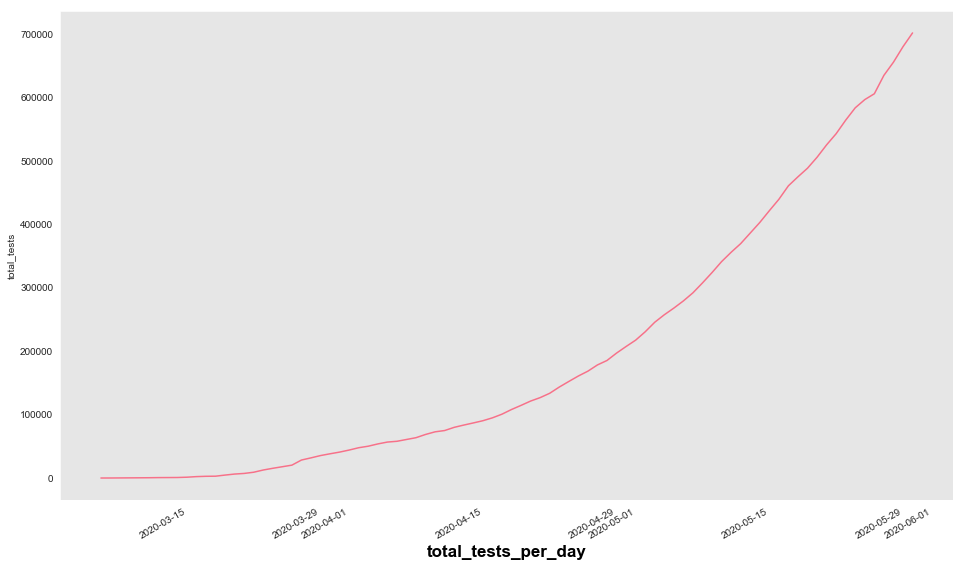

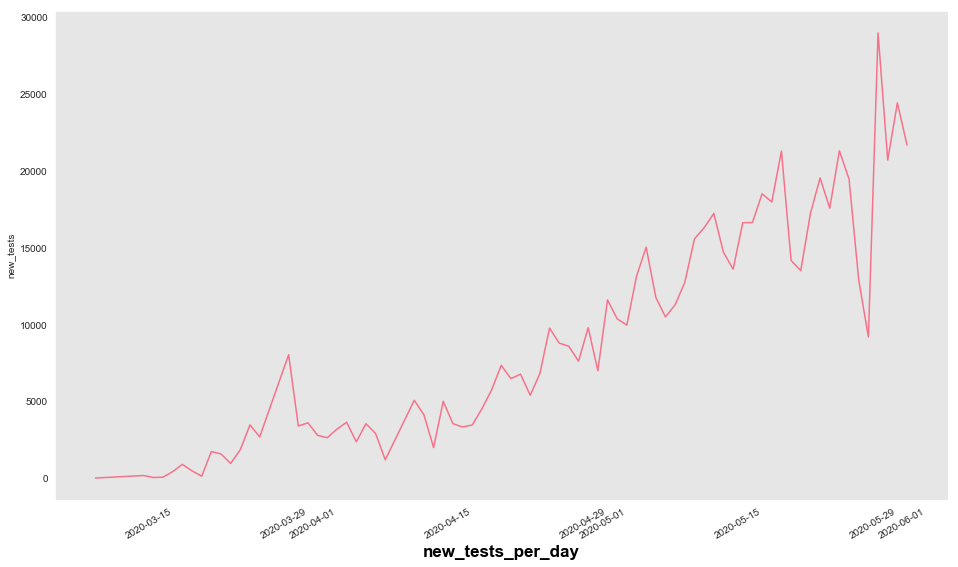

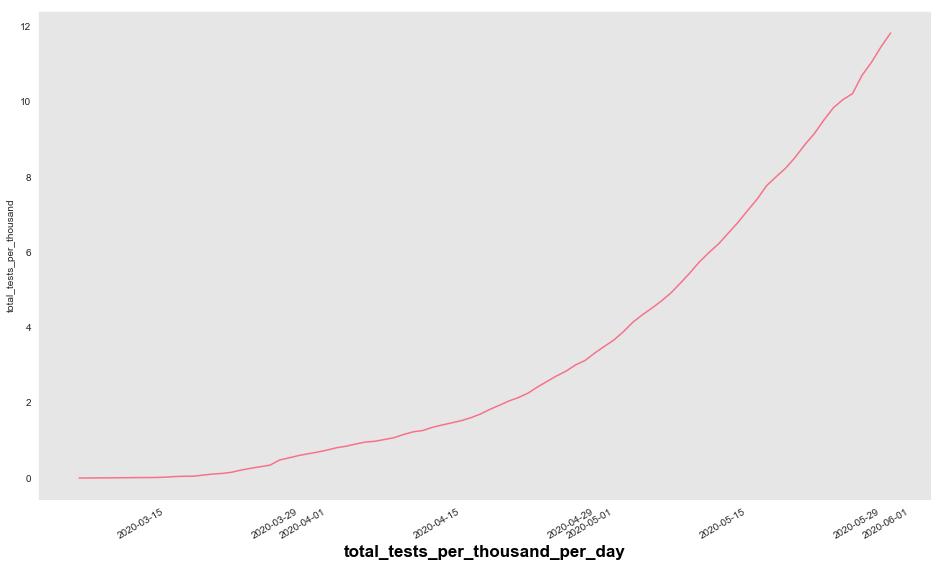

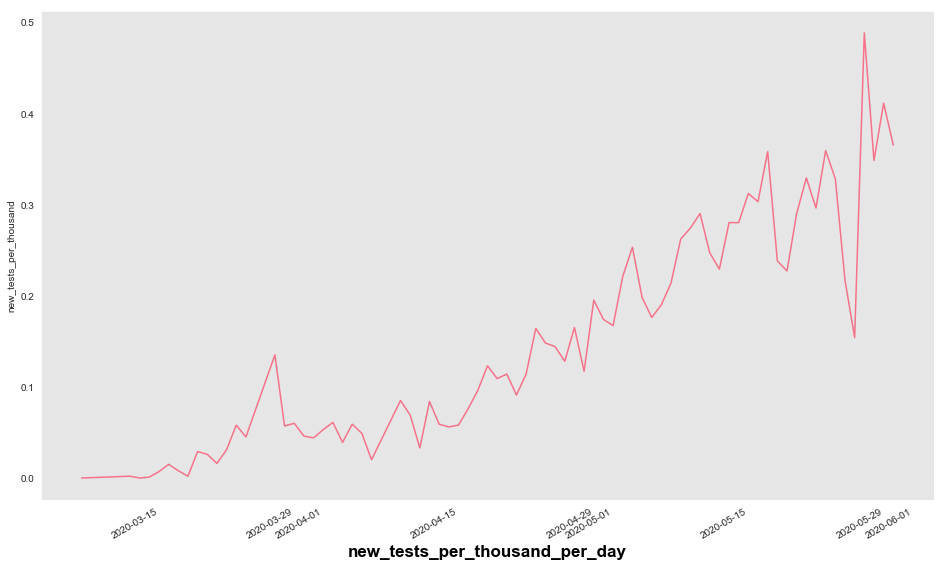

In [5]:
for i in plot_columns:
    plot_colname(df,i)

In [6]:
df[plot_columns].corr()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand
total_cases,1.000000,0.969672,0.996915,0.894842,1.000000,0.969204,0.996941,0.893695,0.985278,0.875556,0.985277,0.875512
new_cases,0.969672,1.000000,0.963425,0.815131,0.969204,1.000000,0.962983,0.812956,0.947965,0.831801,0.947959,0.831728
total_deaths,0.996915,0.963425,1.000000,0.901211,0.996941,0.962982,1.000000,0.900134,0.976567,0.872586,0.976567,0.872538
new_deaths,0.894842,0.815131,0.901211,1.000000,0.893617,0.812843,0.900062,0.999999,0.847920,0.727715,0.847926,0.727661
total_cases_per_million,1.000000,0.969204,0.996941,0.893617,1.000000,0.969204,0.996941,0.893696,0.985188,0.874536,0.985187,0.874486
new_cases_per_million,0.969204,1.000000,0.962982,0.812843,0.969204,1.000000,0.962982,0.812952,0.947069,0.830147,0.947062,0.830068
total_deaths_per_million,0.996941,0.962983,1.000000,0.900062,0.996941,0.962982,1.000000,0.900137,0.976711,0.872136,0.976711,0.872078
new_deaths_per_million,0.893695,0.812956,0.900134,0.999999,0.893696,0.812952,0.900137,1.000000,0.846178,0.725835,0.846184,0.725774
total_tests,0.985278,0.947965,0.976567,0.847920,0.985188,0.947069,0.976711,0.846178,1.000000,0.923014,1.000000,0.922964
new_tests,0.875556,0.831801,0.872586,0.727715,0.874536,0.830147,0.872136,0.725835,0.923014,1.000000,0.923016,0.999997


In [38]:
def profet(df, period):
    model = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True)
    model.fit(df)
    build_forecast = model.make_future_dataframe(periods=period, freq='D')
    forecast = model.predict(build_forecast)
    df_forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    df_forecast[["yhat", "yhat_lower", "yhat_upper"]] = df_forecast[["yhat", "yhat_lower", "yhat_upper"]]-1
    
    mask = df_ds.ds.values.tolist()
    df_forecast = df_forecast[~df_forecast['ds'].isin(mask)]
    model.plot(forecast, xlabel='Date', ylabel='new_cases')
    #df_forecast[df_forecast < 0] = 0
    return df_forecast 

In [26]:
def baysian(df, period):
    
    time_series = df.y.values
    # A linear trend
    linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=1000)
    # A seasonality
    seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=1.0)
    seasonal7= seasonality(period=7, discount=0.99, name='seasonal7', w=1.0)
    # Build a simple dlm
    simple_dlm = dlm(time_series) + linear_trend + seasonal52 + seasonal7 
    # Fit the model
    simple_dlm.fit()
    
    #predictions = np.exp(np.asarray(simple_dlm.predictN(date=60, N=period+1)[0]))-1
    predictions = np.asarray(simple_dlm.predictN(date=60, N=period+1)[0])
    upper=predictions+1.96*np.sqrt(np.var(predictions))
    lower=predictions-1.96*np.sqrt(np.var(predictions))

    start = df_ds.ds.max()
    end = (df_ds.ds.max() + timedelta(days=period+1))
    date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]

    new_date_df = pd.DataFrame(date_generated, columns = ['date'])
    new_date_df['predictions'],new_date_df["upper_limit"],new_date_df["lower_limit"] = predictions, upper, lower
    new_date_df = new_date_df.drop(new_date_df.index[0])
    
    return new_date_df

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


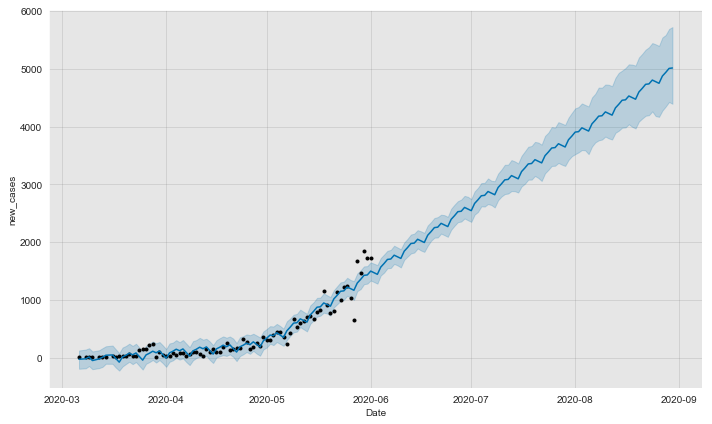

In [39]:
prof_forecast = profet(df_ds, 90)
bays_forecast = baysian(df_ds, 90)
prof_forecast.columns = ['date', 'yhat', 'yhat_lower', 'yhat_upper']
df_final = prof_forecast.merge(bays_forecast, on = 'date', how = 'inner')

In [28]:
df_final['combined_upper'],df_final['combined_pred'],df_final['combined_lower'] = (df_final.yhat_upper+df_final.upper_limit)/2,(df_final.yhat+df_final.predictions)/2,(df_final.yhat_lower+df_final.lower_limit)/2
combined_forecast = df_final[['date','combined_upper','combined_pred','combined_lower']]
combined_forecast.columns = ['date','upper_limit','prediction','lower_limit']
num = combined_forecast._get_numeric_data()
num[num < 0] = 0

In [29]:
bays_forecast.head()

,date,predictions,upper_limit,lower_limit
1,2020-06-02,357.253307,744.331432,-29.824818
2,2020-06-03,371.329337,758.407462,-15.748789
3,2020-06-04,382.833255,769.911380,-4.244871
4,2020-06-05,375.716734,762.794859,-11.361392
5,2020-06-06,356.602631,743.680757,-30.475494


In [30]:
prof_forecast.head()

,date,yhat,yhat_lower,yhat_upper
85,2020-06-02,1626.578889,1477.323044,1769.070897
86,2020-06-03,1613.267791,1467.063979,1756.938298
87,2020-06-04,1749.159062,1606.988306,1886.925093
88,2020-06-05,1823.548841,1668.980649,1964.781916
89,2020-06-06,1904.550045,1763.792813,2054.705691


In [14]:
combined_forecast.head(5)

,date,upper_limit,prediction,lower_limit
0,2020-06-02,31.285484,24.689846,17.871841
1,2020-06-03,30.280086,23.791221,17.167807
2,2020-06-04,32.661235,25.891010,19.412226
3,2020-06-05,32.235893,25.588109,18.949192
4,2020-06-06,32.530942,26.047465,19.534391


In [15]:
combined_forecast.tail(5)

,date,upper_limit,prediction,lower_limit
85,2020-08-26,110.355167,93.536122,76.000279
86,2020-08-27,112.048190,95.375144,78.028805
87,2020-08-28,112.358549,95.960662,78.202339
88,2020-08-29,114.397653,96.671420,78.616942
89,2020-08-30,113.181977,95.604359,77.767621


In [ ]:
#prophet evaluation
def mape(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mask = df_ds.ds.values.tolist()
test_df = forecast[forecast['ds'].isin(mask)]
yhat = np.exp(test_df['yhat'].values)
actual = np.exp(df_ds['y'].values)

mape_val = mape(actual,yhat)
mape_val

243091.0

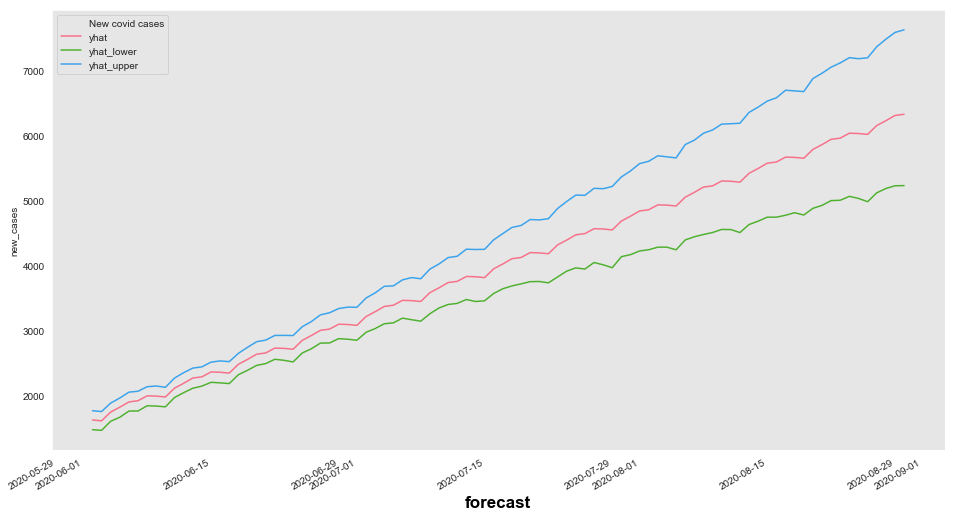

In [31]:
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(111)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
ax1.grid(False)
sns.set_palette("husl", 2)

data1 = prof_forecast.melt('date', var_name='New covid cases',  value_name='new_cases')

sns.lineplot(x  = 'date', y = 'new_cases',data = data1, ax = ax1, ci = None, hue = 'New covid cases')
fig.autofmt_xdate()
plt.xlabel('forecast', fontweight='bold', color = 'k', fontsize='17', horizontalalignment='center')
(df_ds.y.sum() + combined_forecast.prediction.sum()).round(0)

In [ ]:
(df_ds.y.sum() + combined_forecast.upper_limit.sum()).round(0)